# QUANTUM AMPLITUDE AMPLIFICATION

In this tutorial, we provide a detailed discussion and implementation of the Quantum Amplitude Amplification (QAA) algorithm using the Amazon Braket SDK. 
QAA is a routine in quantum computing which generalizes the idea behind Grover's famous search algorithm, with applications across many quantum algorithms. 
In short, QAA uses an iterative approach to systematically increase the probability of finding one or multiple target states in a given search space. 
In a quantum computer, QAA can be used to obtain a _quadratic speedup_ over several classical algorithms [[1]](#References).

## TECHNICAL BACKGROUND OF QAA

__Formal introduction of QAA__: We start off with a brief formal introduction to QAA, following standard references [[1-4]](#References). 
In the lines that follow, we provide a pictorial derivation of QAA, giving an intuitive background to the derivation shown here. 
Consider a unitary $\mathcal{A}$ acting on $(n+1)$ qubits as follows 

$$\mathcal{A}|0\rangle _{n+1} = |\psi\rangle = \sqrt{a} |G\rangle |1\rangle + \sqrt{1-a} |B\rangle |0\rangle,$$

where $a \in [0,1]$ is the amplitude we wish to amplify. 
Setting $\sqrt{a} = \sin(\theta)$, equivalently we can write

$$\mathcal{A}|0\rangle _{n+1} = |\psi\rangle = \sin(\theta) |G\rangle |1\rangle + \cos(\theta) |B\rangle |0\rangle.$$

Here, we have introduced the $n$-qubit states $|G\rangle$ and $|B\rangle$ by convention referred to as _good_ and _bad_ states, respectively. 
The states $|\psi_{1}\rangle = |G\rangle |1\rangle$ and $|\psi_{0}\rangle = |B\rangle |0\rangle$ are (unique) projections of the original state $|\psi\rangle$ into good and bad subspaces, denoted as $\mathcal{H}_{1}$ and $\mathcal{H}_{0}$, respectively. Note that $|\psi_{1}\rangle$ and $|\psi_{0}\rangle$ are orthogonal, i.e., $ \langle \psi_{0}|\psi_{1}\rangle = \langle B|G\rangle \langle 0|1\rangle =0$, because $\langle 0|1\rangle =0$.

__Goal of QAA__: The goal of the algorithm is then to evolve the initial state $|\psi \rangle \in \mathcal{H}$ into a state with a higher overlap with the _good_ subspace $\mathcal{H}_{1}$ by _amplifying_ the amplitude of the $|\psi_{1}\rangle$ component of the state.

The amplification process that follows boosts the amplitude of the good state $|G\rangle$ from $\sin(\theta)$ to $\sin((2m+1)\theta)$ with $2m$ denoting the number of _queries_ or applications of the unitary $\mathcal{A}$. The probability of finding a _good_ outcome is maximized when $m=\left\lfloor\frac{\pi}{4\theta}\right\rfloor$.

__Procedure of QAA__: Rather than directly taking measurements on $|\psi\rangle$ (as prepared by a _single_ application of $\mathcal{A}$), QAA proceeds by applying the following operator $\mathcal{Q}$ (that is derived from $\mathcal{A}$, i.e., taking $\mathcal{A}$ as an input), 

$$\mathcal{Q}=\mathcal{A} \mathcal{R}_{0} \mathcal{A}^{\dagger} \mathcal{R}_{B}.$$

Here, 
$\mathcal{R}_{0}=2|0\rangle_{n+1} \langle 0| - \mathbb{1}$
is a reflection about $|0\rangle_{n+1}$ (leaving the all-zero state $|0\rangle_{n+1}$ untouched while giving a minus sign to all other states) and similarly 
$\mathcal{R}_{B} = \mathbb{1} - 2 |G\rangle |1\rangle \langle 1|\langle G|$ 
is a reflection about $|B\rangle |0\rangle$, giving a negative sign on the good state, as $\mathcal{R}_{B} |G\rangle |1\rangle = -1|G\rangle |1\rangle$, while leaving the bad state $|B\rangle |0\rangle$ untouched.
Finally, $\mathcal{A}^{\dagger}$ denotes the adjoint of $\mathcal{A}$. 
As demonstrated in Refs.[[2,3]](#References), repeated application of the operator $\mathcal{Q}$ ($m$-times) on $|\psi\rangle = \mathcal{A}|0\rangle _{n+1}$ gives

$$\mathcal{Q}^{m} |\psi\rangle = \mathcal{Q}^{m}\mathcal{A}|0\rangle _{n+1} = \sin((2m+1)\theta) |G\rangle |1\rangle + \cos((2m+1)\theta) |B\rangle |0\rangle.$$

In a nutshell, this equation shows that, for small values of the unknown parameter $a$, the repeated application of $Q$ (involving $2m$ queries of $\mathcal{A}$ in total) yields a state for which the desired good state would be measured with a probability at least $4m^{2}$ times larger than that of a naive strategy as obtained from $\mathcal{A}|0\rangle _{n+1}$. 
This result is because the probability of measuring the good state $|G\rangle |1\rangle$ is $P_{1}=\sin^{2}((2m+1)\theta) \approx (2m+1)^{2}\theta^{2}>4m^{2} \theta^{2}$. 
Compare this to $2m$ naive queries, i.e., $2m$ measurements from copies of the state $\mathcal{A}|0\rangle _{n+1}$ which gives the good state with linear increase in probability $2m$. 
This reasoning is at the heart of the quadratic speedup obtained with QAA: the probability of measuring the good state after QAA scales quadratically with $m$ instead of linearly, meaning we only need $O(\sqrt{m})$ queries of $\mathcal{A}$ to achieve the same probability of measuring $|G\rangle$ compared to the classical strategy. 
Specifically, if $(2m+1)\theta \approx \pi/2$, we have amplified the success probability to $\sin(...)^{2} \approx 1$. 

Because $\mathcal{A}$ is an input to QAA that we assume is given, our goal is to figure out how to implement $\mathcal{R}_{B}$, $\mathcal{R}_{0}$, and $\mathcal{A}^{\dagger}$ as unitaries in a quantum circuit.
This work is shown in detail in the lines that follow. 

__Intuition for QAA__: The previous discussion follows the canonical, formal introduction to QAA. 
This section provides a pictorial derivation of the QAA routine, which helps to get an intuitive understanding of the definition and the role of the operator $\mathcal{Q}$ introduced previously. 
As shown previously, the two states $|\psi_{1}\rangle = |G\rangle |1\rangle$ and $|\psi_{0}\rangle = |B\rangle |0\rangle$ are orthogonal, and the whole problem can be analyzed in the two-dimensional subspace spanned by these two orthogonal vectors, with real amplitudes. 
Since the length of the vectors involved are preserved (that is, the vectors remain normalized) we can visualize the whole QAA procedure as transformations of a point on a simple circle, as shown below, using the good and bad states $|G\rangle |1\rangle$ and $|B\rangle |0\rangle$ as basis vectors, respectively. 

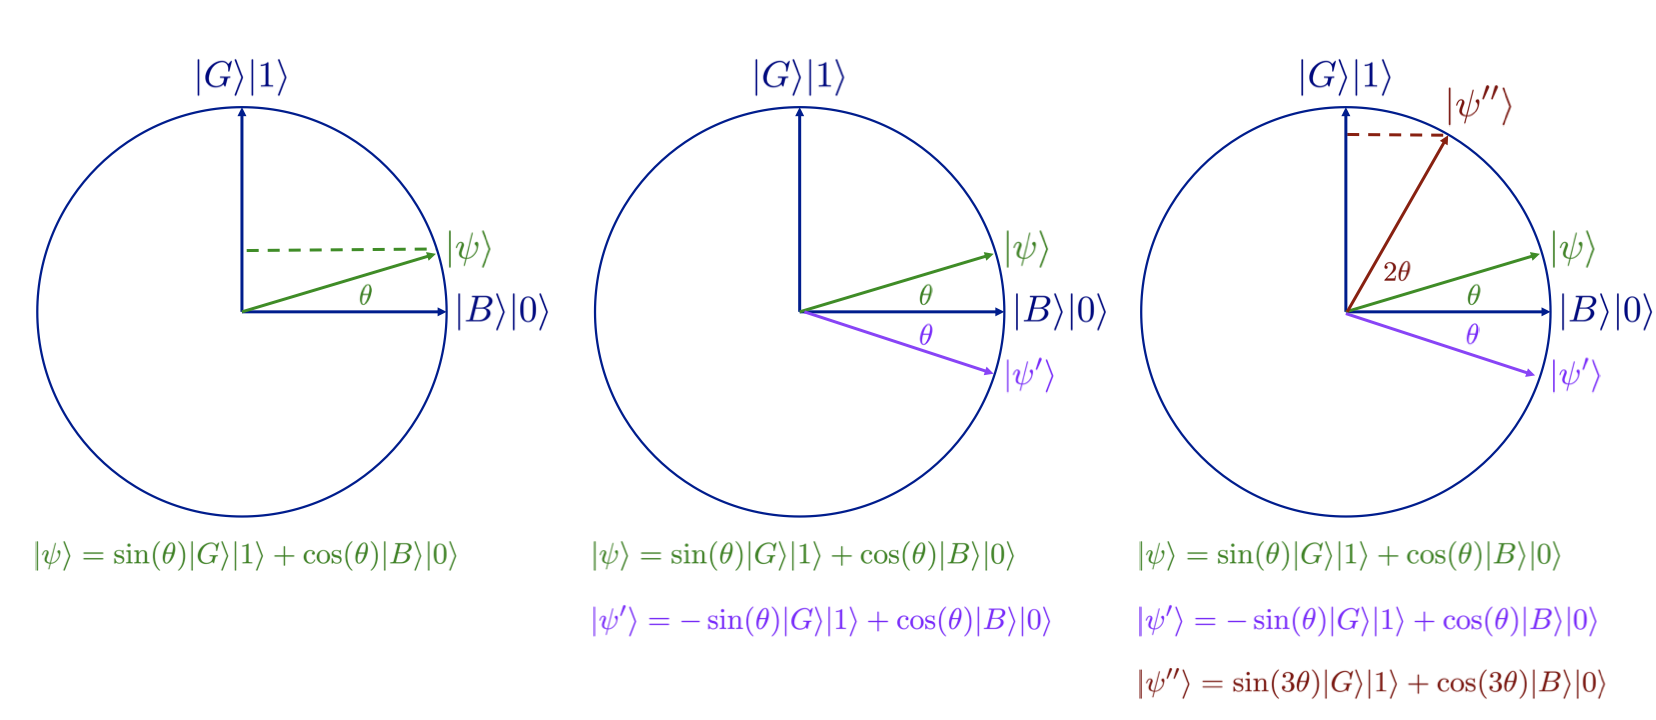

In [5]:
from IPython.display import Image
Image(filename='vectors.png')

Going from left to right in the image above, the QAA routine proceeds as follows:

1. __Original situation__: First, the original state prepared by $\mathcal{A}$ as $|\psi\rangle = \mathcal{A}|0\rangle _{n+1} = \sin(\theta) |G\rangle |1\rangle + \cos(\theta) |B\rangle |0\rangle$ resides in the two-dimensional plane spanned by the basis vectors $|G\rangle |1\rangle$ and $|B\rangle |0\rangle$, respectively, with (typically small) projection $\sin(\theta)$ onto the $|G\rangle |1\rangle$ axis.
2. __Reflection about $|B\rangle |0\rangle$__: We then apply a reflection around $|B\rangle |0\rangle$, transforming $|\psi\rangle$ to $|\psi'\rangle$, keeping the projection along $|B\rangle |0\rangle$ unchanged, but adding a minus sign to the $|G\rangle |1\rangle$ component. Reflection about $|B\rangle |0\rangle$ means that all terms apart from $|B\rangle |0\rangle$ pick up a negative sign. Because there are only two terms, only $|G\rangle |1\rangle$ picks up a negative sign, which is accomplished by the operator $\mathcal{R}_{B} = \mathbb{1} - 2 |G\rangle |1\rangle \langle 1|\langle G|$, as defined previously. 
3. __Reflection about $|\psi\rangle$__: Finally, we apply a reflection around the original state $|\psi\rangle$, giving the final state $|\psi''\rangle$, with an amplified $|G\rangle |1\rangle$ amplitude of $\sin(3\theta)$, adding an angle of $2\theta$ from the rotation around $|\psi\rangle$ to the original angle $\theta$.
Reflection about $|\psi\rangle$ means that all terms except for $|\psi\rangle$ pick up a minus sign, as can be done by applying the operator $\mathcal{R}_{\psi} = 2|\psi\rangle\langle\psi| - \mathbb{1}$. 
Using the definition $|\psi\rangle = \mathcal{A}|\vec{0}\rangle$ and conversely $\langle \psi | = \langle \vec{0}|\mathcal{A}^{\dagger}$ as well as the unitarity condition $\mathcal{A}\mathcal{A}^{\dagger}=\mathbb{1}$, this reflection can be rewritten as $\mathcal{R}_{\psi} = \mathcal{A}\mathcal{R}_{0}\mathcal{A}^{\dagger}$, where $\mathcal{R}_{0}=2|\vec{0}\rangle\langle\vec{0}| - \mathbb{1}$ is a reflection about the all-zero state $|\vec{0}\rangle$ where all terms except for $|\vec{0}\rangle$ pick up a minus sign. 

This sequence completes one cycle of the QAA routine, that is one application of $\mathcal{Q}$. 
In total, each application of $Q$ involves two reflections, first through $|B\rangle |0\rangle$ and then through $|\psi\rangle$. 
The product is a rotation with angle $2\theta$. 
Based on our analysis above we can write the rotation $\mathcal{Q}$ as 

$$\mathcal{Q} = \mathcal{R}_{\psi}\mathcal{R}_{B} = \mathcal{A}\mathcal{R}_{0}\mathcal{A}^{\dagger}\mathcal{R}_{B},$$

thereby confirming the formal definition above. 
Repeating this sequence, after $m$ iterations of $\mathcal{Q}$ we get the generalized equation

$$\mathcal{Q}^{m} |\psi\rangle = \sin((2m+1)\theta) |G\rangle |1\rangle + \cos((2m+1)\theta) |B\rangle |0\rangle.$$


__Obtaining a quantum speedup__:
To see that QAA indeed provides a quantum speedup, suppose we use it to query an unsorted database with $N$ elements and $G$ _good_ elements. 
The classical algorithm for finding good entries is to query each element in the database until a good one is found. Thus, the classical solution requires $O(N/G)$ queries. 
A quantum solution would be to query the database in superposition using the state $1/\sqrt{N}\sum_i|j\rangle$, where $j$ enumerates the $N$ elements of the database. 
The oracle prepares the state

$$|\psi\rangle = \sqrt{\frac{G}{N}} |G\rangle |1\rangle + \sqrt{\frac{N-G}{N}} |B\rangle |0\rangle.$$

Thus, $\sqrt{a}=\sin(\theta)=\sqrt{G/N}$ and $\theta \approx \sqrt{G/N}$ for the typical scenario where $\theta \ll 1$.

We then apply the QAA algorithm to amplify the amplitude of the good states, such that the probability of obtaining a _good_ outcome is amplified. 
To ensure that we measure a good outcome with high probability, we apply the Grover iterator $\left\lfloor\frac{\pi}{4\theta}\right\rfloor=\left\lfloor\frac{\pi}{4}\sqrt{\frac{N}{G}}\right\rfloor$ times. 
In other words, we only need to query the oracle $O(\sqrt{N/G})$ times in order to find a good outcome to the search problem with high probability.
This outcome is a quadratic improvement over the $O(N/G)$ oracle calls required classically. 

## CIRCUIT IMPLEMENTATION OF QAA

__Implementation of QAA on a QC__: Now that we have an intuitive understanding for QAA (after all, it is just a rotation, as illustrated previously), the final puzzle piece that remains to be solved is the actual implementation of the reflections $\mathcal{R}_{B}$ and $\mathcal{R}_{0}$ as a quantum circuit (since $\mathcal{A}$ is given as input to the QAA problem). 
Rather than implementing $\mathcal{R}_{0}$ below, we will show how to implement 

$$-\mathcal{R}_{0} = \mathbb{1} - 2|0\rangle_{n+1} \langle 0|,$$ 

which gives a minus sign to $|0\rangle_{n+1}$ only, leaving all other states untouched. 
To compensate for this minus sign, overall we will show how to implement the unitary 
$$\mathcal{Q}=\mathcal{A} (-\mathcal{R}_{0}) \mathcal{A}^{\dagger} (-\mathcal{R}_{B}).$$

__Implementation of $-\mathcal{R}_{B}$__: First, let us consider 

$$-\mathcal{R}_{B} = 2 |G\rangle |1\rangle \langle 1|\langle G| - \mathbb{1},$$ 

which is a reflection about $|G\rangle |1\rangle$, because $-\mathcal{R}_{B} |G\rangle |1\rangle = +1|G\rangle |1\rangle$ and $-\mathcal{R}_{B} |B\rangle |0\rangle = -1|B\rangle |0\rangle$. 
This transformation can be achieved by applying $X_{n+1}Z_{n+1}X_{n+1}$ to the (last) ancilla qubit. 
This way, we obtain a minus sign whenever the ancilla is in the $|0\rangle$ state. 

__Implementation of $-\mathcal{R}_{0}$__: We must implement the transformation $|0, \dots, 0\rangle \rightarrow -|0, \dots, 0\rangle$, while leaving all other states untouched. 
To this end, we can flip all the qubits (using single-qubit $X$ gates), flipping the sign of $|11...1\rangle$, and flipping the qubits back. 
Thus, the last operation that remains to be defined explicitly is flipping the sign of $|11...1\rangle$ , which can be done with ancilla qubits. 
One possible way to do this task is by using a multiply-controlled Toffoli gate:
First apply a Pauli-$X$ gate to each qubit. 
Then apply the $N+1$ qubit Toffoli, controlled on all $N$ of the qubits we want to test, and targeted on a single ancilla qubit. 
If (and only if) all of the qubits were in the zero state, then the ancilla qubit will be flipped to $|1\rangle$. 
We then apply a $Z$ gate to the ancilla qubit, so the overall wavefunction picks up a minus sign whenever all of the register qubits are in the $|0\rangle$ state. 
Finally, we uncompute the ancilla by applying another $N+1$ qubit Toffoli gate.

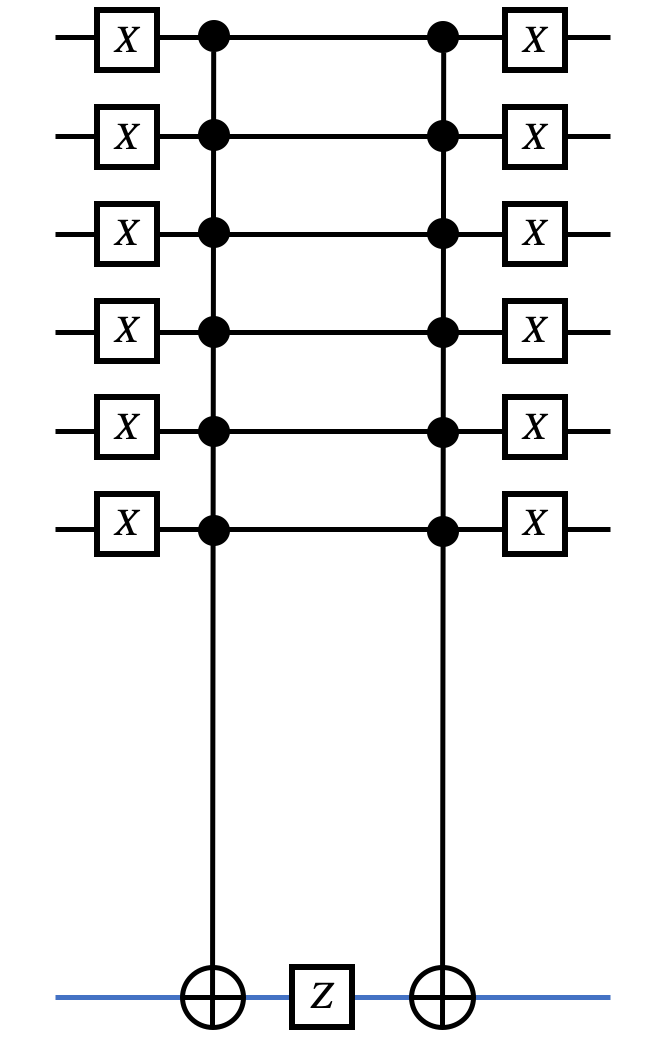

In [6]:
Image(filename='R0.png')

We can decompose the $N+1$ qubit Toffoli gate into $N-1$ CCNOT (that is, 3 qubit Toffoli) gates and $N-1$ ancilla qubits, shown as follows for $N=4$ register qubits: 

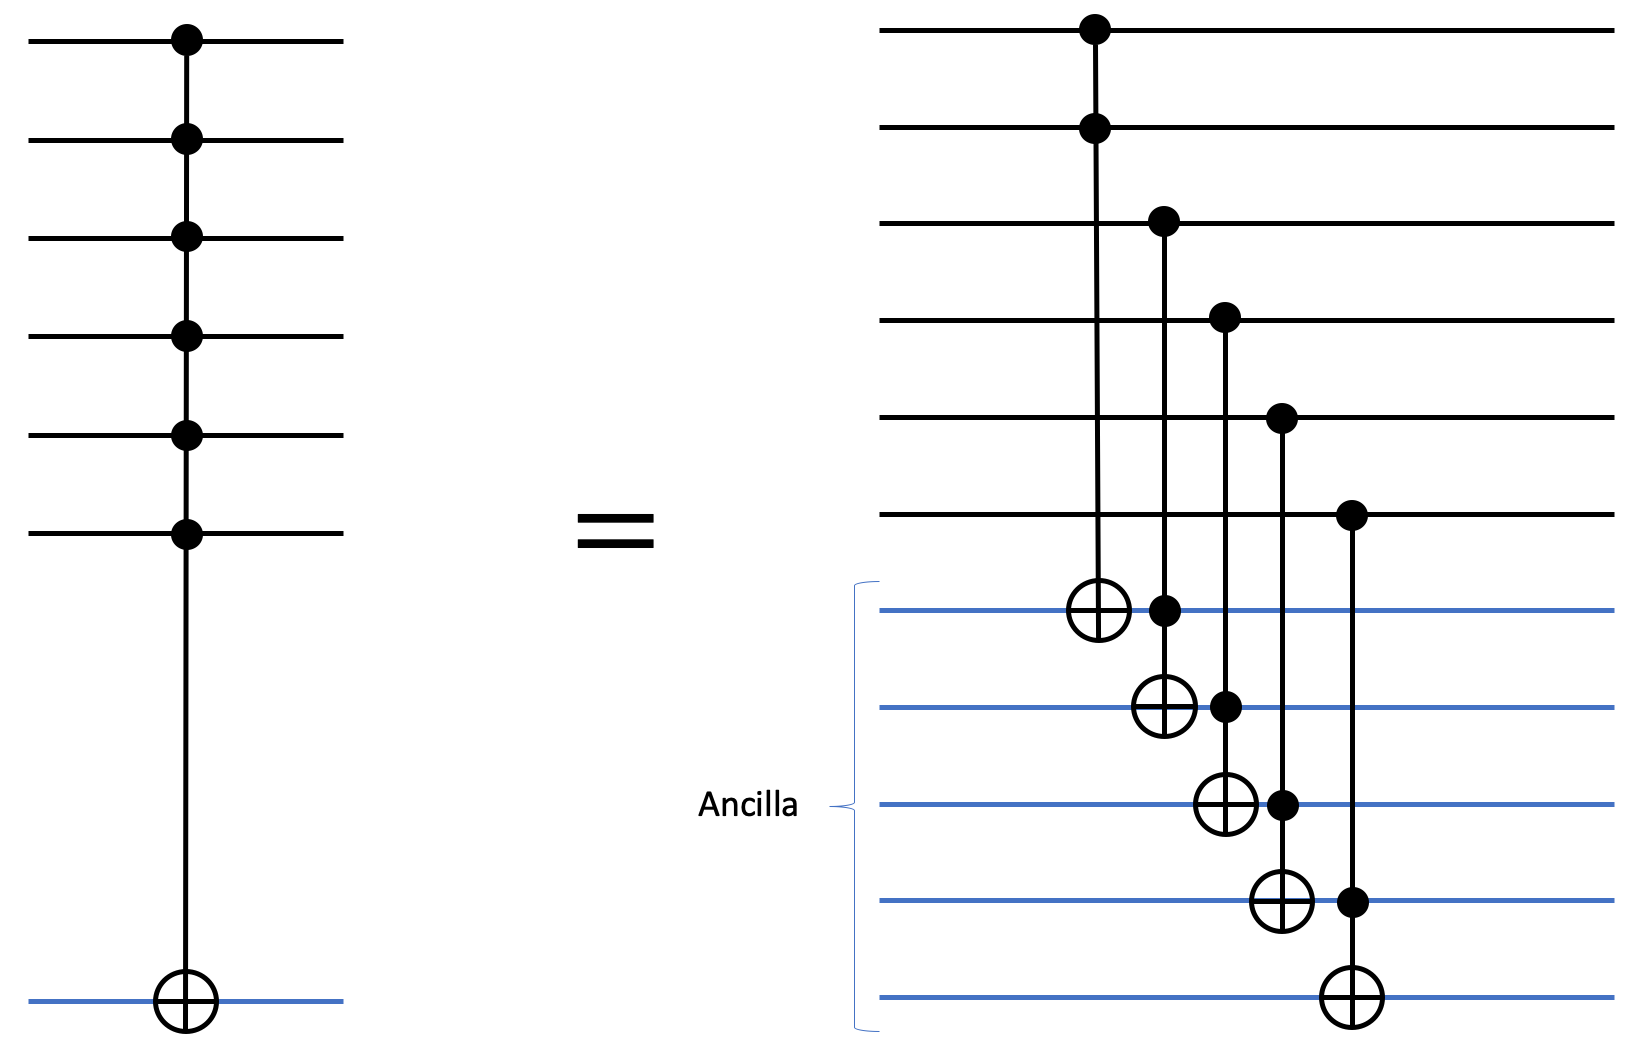

In [7]:
Image(filename='Toffoli_decomp.png')

Thus, the final circuit can be implemented using ancilla qubits as

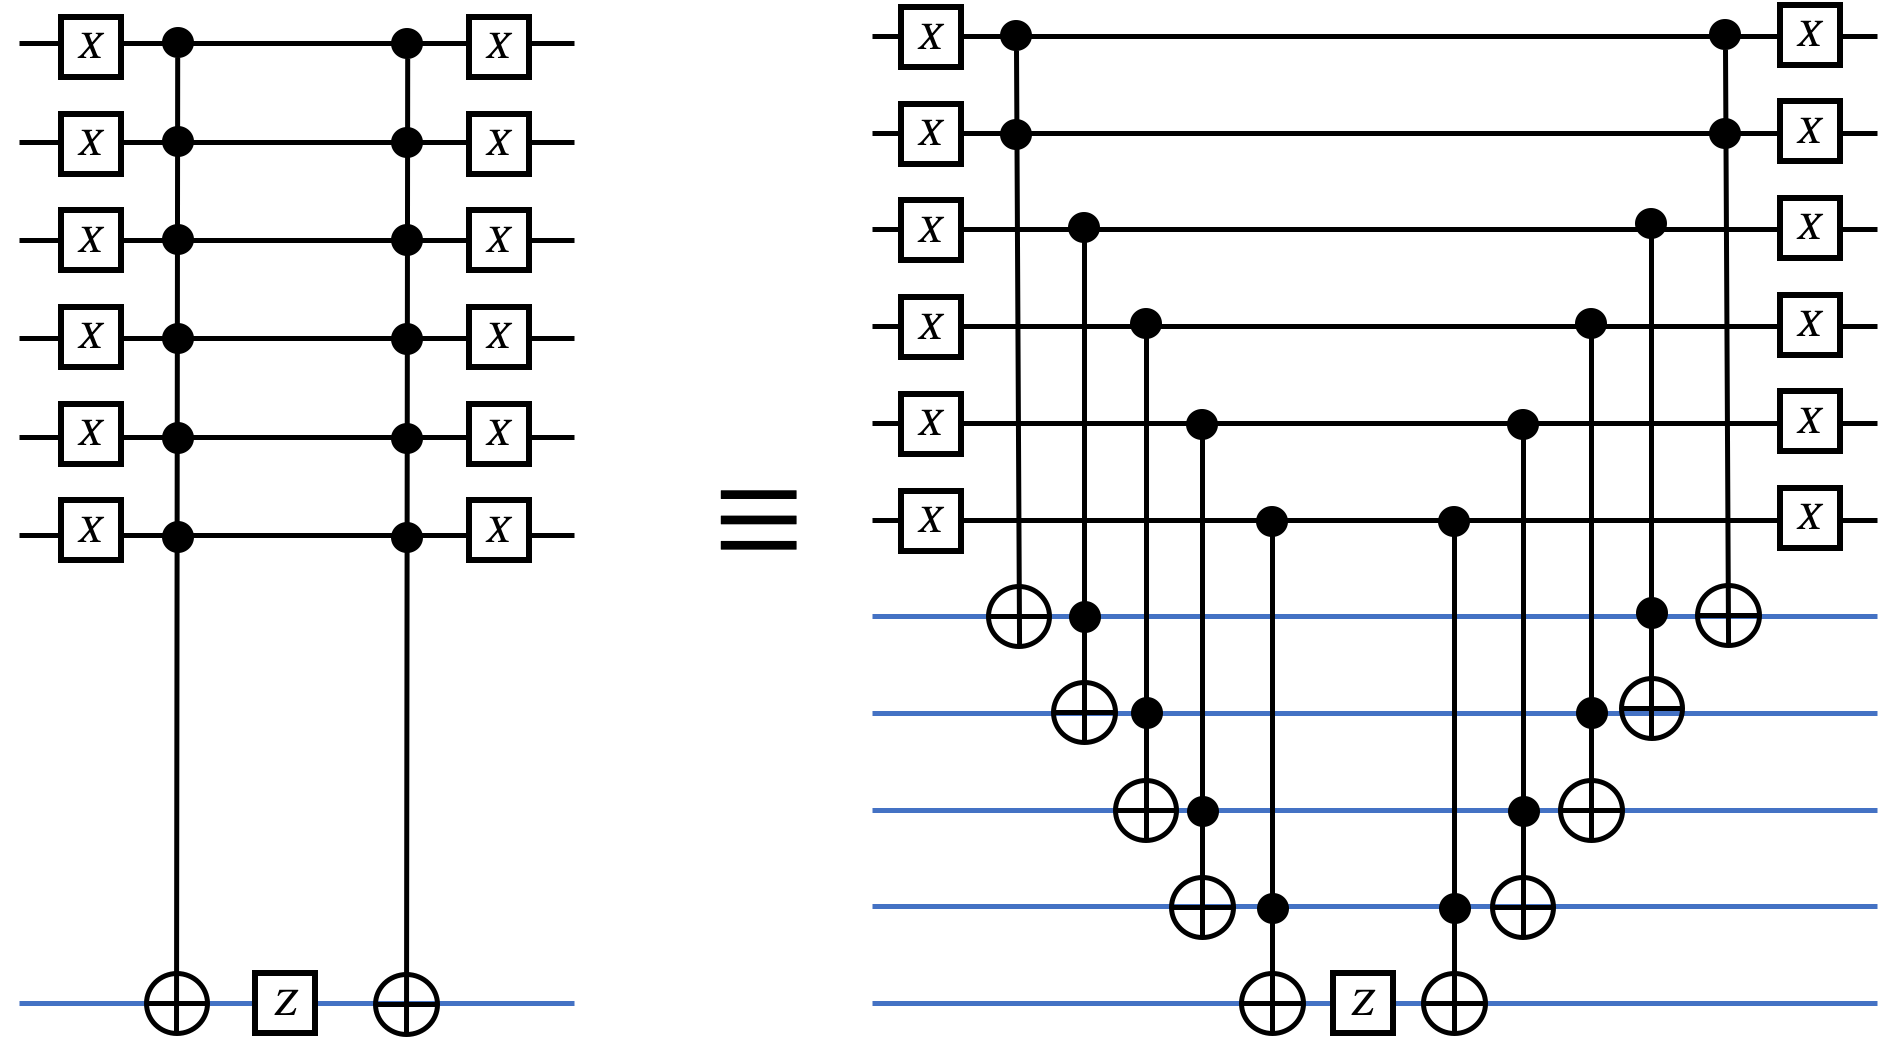

In [8]:
Image(filename='R_full.png')

## IMPORTS and SETUP

In [1]:
# general imports
import numpy as np
import math
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
# AWS imports: Import Braket SDK modules
from braket.circuits import Circuit, circuit
from braket.devices import LocalSimulator
from braket.aws import AwsSession, AwsDevice

In [3]:
# local imports
from utils_circuit import get_unitary, adjoint
from utils_qaa import qaa

# monkey patch get_unitary() and adjoint() to the Circuit class
Circuit.get_unitary = get_unitary
Circuit.adjoint = adjoint

In [4]:
# set up device: Local Schroedinger Simulator
device = LocalSimulator()

## IMPLEMENTATION OF REFLECTION OPERATORS

In ```utils_qaa.py``` we provide a set of simple helper functions to implement the quantum circuit for the QAA algorithm. 
Specifically, we demonstrate how such modular building blocks can be registered as subroutines, using ```@circuit.subroutine(register=True)```. 
Here we first highlight the implementation of the reflections $-\mathcal{R}_{B}$ and $-\mathcal{R}_{0}$ as discussed previously. The functions defined as follows comprise the ```utiles_qaa.py``` module.

### REFLECTION AROUND $|B\rangle |0\rangle$

We need to apply a minus sign to $|B\rangle |0\rangle$ only. We achieve this goal by applying $XZX$ to the ancilla qubit, so that we obtain a minus sign whenever the ancilla is in the $|0\rangle$ state.

```python
# helper function to apply XZX to given qubit
@circuit.subroutine(register=True)
def minus_R_B(qubit):
    """
    Function to apply a minus sign to |B>|0>. This goal is achieved by applying XZX to the ancilla qubit.

    Args:
        qubit: the ancilla qubit on which we apply XZX.
    """
    # instantiate circuit object
    circ = Circuit()
    
    # Apply sequence XZX to given qubit
    circ.x(qubit).z(qubit).x(qubit)
    
    return circ
```

### REFLECTION AROUND $|0\rangle^{\otimes n+1}$

We must implement $-\mathcal{R}_{0}$, which gives a minus sign to $|0\rangle_{n+1}$ only, leaving all other states untouched. 
To this end, we implement the circuit visualized previously using ancilla qubits; alternatively, as controlled by the flag ```use_explicit_unitary```, one can evolve the system with the the unitary $\mathrm{diag}(-1,1,1,...,1)$.
This way, we can run QAA on _classical_ simulators without the need to resort to ancilla qubits. 

```python
# Helper function to apply rotation -R0
@circuit.subroutine(register=True)
def minus_R_zero(qubits, use_explicit_unitary=False):
    """
    Function to implement transformation: |0,0,...0> -> -|0,0,...0>, all others unchanged. 

    Args:
        qubits: list of qubits on which to apply the gates
        use_explicit_unitary (default False): Flag to specify that we could instead implement
        the desired gate using a custom gate defined by the unitary diag(-1,1,...,1).
    """

    circ = Circuit()
    
    # If the use_explicit_matrix flag is True, we just apply the unitary defined by |0,0,...0> -> -|0,0,...0>
    if use_explicit_unitary:
        # Create the matrix diag(-1,1,1,...,1)
        unitary = np.eye(2**len(qubits))
        unitary[0][0]=-1
        # Add a gate defined by this matrix
        circ.unitary(matrix=unitary, targets=qubits)
    
    # Otherwise implement the unitary using ancilla qubits:
    else:
        # Flip all qubits. We now must check whether all qubits are |1>, rather than |0>.
        circ.x(qubits)

        # If we have only 1 qubit, we only must apply XZX to that qubit to pick up a minus sign on |0>
        if len(qubits) < 2:
            circ.z(qubits)

        # For more qubits, we use Toffoli (or CCNOT) gates to verify the qubits are in |1> (after applying X)
        else:

            # Dynamically add ancilla qubits, starting on the next unused qubit in the circuit
            # NOTE: if this subroutine is being applied to a subset of qubits in a circuit, these ancilla
            # registers may already be used. We could pass in circ as an argument and add ancillas outside of
            # circ.targets instead, if desired.
            ancilla_start = max(qubits) + 1

            # Check that the first two register qubits are both 1's using a CCNOT on a new ancilla qubit.
            circ.ccnot(qubits[0],qubits[1],ancilla_start)

            # Now add a CCNOT from each of the next register qubits, comparing with the ancilla we just added.
            # Target on a new ancilla. If len(qubits) is 2, this does not execute.
            for ii,qubit in enumerate(qubits[2:]):
                circ.ccnot(qubit,ancilla_start+ii, ancilla_start+ii+1)

            # A Z gate applied to the last ancilla qubit gives a minus sign if all register qubits are |1>
            ancilla_end = ancilla_start + len(qubits[2:])
            circ.z(ancilla_end)

            # Now uncompute to disentangle the ancilla qubits by applying CCNOTs in the reverse order to the previous.
            for jj,qubit in enumerate(reversed(qubits[2:])):
                circ.ccnot(qubit,ancilla_end-jj-1, ancilla_end-jj)

            # Finally undo the last CCNOT on the first two register qubits.
            circ.ccnot(qubits[0],qubits[1],ancilla_start)

        # Flip all qubits back
        circ.x(qubits)
    
    return circ
```

## VISUALIZATION OF THE CIRCUIT FOR THE REFLECTION $\mathcal{R}_{0}$

To check our implementation of the $-\mathcal{R}_{0}$ circuit discussed previously, let us visualize this circuit for small number of qubits. 
Note that our implementation accepts a list of qubit indices with arbitrary index ordering. 

### Example circuit with four qubits and simple index ordering:

In [5]:
qubits = [0,1,2,3]
circ = Circuit()
circ.minus_R_zero(qubits)
print(circ)

T  : |0|1|2|3|4|5| 6 | 7 |8|
                            
q0 : -X-C-------------C---X-
        |             |     
q1 : -X-C-------------C---X-
        |             |     
q2 : -X-|-C-------C---|-X---
        | |       |   |     
q3 : -X-|-|-C---C-|-X-|-----
        | | |   | |   |     
q4 : ---X-C-|---|-C---X-----
          | |   | |         
q5 : -----X-C---C-X---------
            |   |           
q6 : -------X-Z-X-----------

T  : |0|1|2|3|4|5| 6 | 7 |8|


### Example with four qubits and arbitrary index ordering:

Note that the simulators require contiguous qubit indexing, while our algorithm does not.

In [6]:
qubits = [1, 0, 5, 4]
circ = Circuit()
circ.minus_R_zero(qubits)
print(circ)

T  : |0|1|2|3|4|5|6| 7 |8|
                          
q0 : -X-C-----------C---X-
        |           |     
q1 : -X-C-----------C---X-
        |           |     
q4 : -X-|---C---C-X-|-----
        |   |   |   |     
q5 : -X-|-C-|---|-C-|-X---
        | | |   | | |     
q6 : ---X-C-|---|-C-X-----
          | |   | |       
q7 : -----X-C---C-X-------
            |   |         
q8 : -------X-Z-X---------

T  : |0|1|2|3|4|5|6| 7 |8|


## IMPLEMENTATION OF QAA 

This section puts everything together and shows how to implement QAA using the subroutines given previously. 
We first build a function ```grover_iterator(...)``` that implements the Grover iterator $\mathcal{Q}=\mathcal{A} \mathcal{R}_{0} \mathcal{A}^{\dagger} \mathcal{R}_{B}$, given the unitary $\mathcal{A}$ and the so-called flag qubit labeling the good/bad subspaces. 
Given this implementation for the Grover iterator $\mathcal{Q}$ it is straightforward to implement a QAA routine ```qaa(...)``` which repeatedly applies the iterator $\mathcal{Q}$ for a given number of iterations. 

The full code (imported into this notebook in the [imports and setup](#IMPORTS-and-SETUP) section) is available in the module ```utils_qaa.py```. 

```python
@circuit.subroutine(register=True)
def grover_iterator(A,flag_qubit,qubits=None,use_explicit_unitary=False):
    """
    Function to implement the Grover iterator Q=A R_0 A* R_B. 

    Args:
        A: Circuit defining the unitary A
        flag_qubit: Specifies which of the qubits A acts on labels the good/bad subspace.
                    Must be an element of qubits (if passed) or A.qubits.
        qubits: list of qubits on which to apply the gates (including the flag_qubit).
                If qubits is different from A.qubits, A is applied to qubits instead.
        use_explicit_unitary: Flag to specify that we should implement R_0 using using a custom
                              gate defined by the unitary diag(-1,1,...,1). Default is False.
    """
    # If no qubits are passed, apply the gates to the targets of A
    if qubits is None:
        qubits = A.qubits
    else:
        # If qubits are passed, make sure it's the right number to remap from A.
        if len(qubits)!=len(A.qubits):
            raise ValueError('Number of desired target qubits differs from number of targets in A'.format(flag_qubit=repr(flag_qubit)))
    
    # Verify that flag_qubit is one of the qubits on which A acts, or one of the user defined qubits
    if flag_qubit not in qubits:
        raise ValueError('flag_qubit {flag_qubit} is not in targets of A'.format(flag_qubit=repr(flag_qubit)))
    
    # Instantiate the circuit
    circ = Circuit()
    
    # Apply -R_B to the flag qubit
    circ.minus_R_B(flag_qubit)
    
    # Apply A^\dagger. Use target mapping if different qubits are specified
    circ.add_circuit(A.adjoint(),target=qubits)
    
    # Apply -R_0
    circ.minus_R_zero(qubits,use_explicit_unitary)
    
    # Apply A, mapping targets if desired.
    circ.add_circuit(A,target=qubits)
    
    return circ
```

```python
@circuit.subroutine(register=True)
def qaa(A,flag_qubit,num_iterations,qubits=None,use_explicit_unitary=False):
    """
    Function to implement the Quantum Amplitude Amplification Q^m, where Q=A R_0 A* R_B, m=num_iterations. 

    Args:
        A: Circuit defining the unitary A
        flag_qubit: Specifies which of the qubits A acts on labels the good/bad subspace.
                    Must be an element of qubits (if passed) or A.qubits.
        num_iterations: number of applications of the Grover iterator Q.
        qubits: list of qubits on which to apply the gates (including the flag_qubit).
                If qubits is different from A.qubits, A is applied to qubits instead.
        use_explicit_unitary: Flag to specify that we should implement R_0 using using a custom
                              gate defined by the unitary diag(-1,1,...,1). Default is False.
    """
    # Instantiate the circuit
    circ = Circuit()
    
    # Apply the Grover iterator num_iterations times:
    for _ in range(num_iterations):
        circ.grover_iterator(A,flag_qubit,qubits,use_explicit_unitary)
    
    return circ
```

## NUMERICAL EXAMPLE

This section shows how to use QAA to amplify the amplitude of $|11\rangle$ of a two-qubit state, thereby increasing the entanglement between the two qubits. Consider a single qubit in the state 

$$|\psi\rangle=\sqrt{1-\delta^2}|0\rangle + \delta |1\rangle,$$

where $\delta$ is small. This state can be prepared using a small rotation around the $y$ direction:

$$R_y(\epsilon)|0\rangle=|\psi\rangle,$$

where $\epsilon$ is chosen to give a coefficient of $\delta=\sin(\epsilon/2) \approx \epsilon/2$ to $|1\rangle$.

Suppose $|1\rangle$ is the "good" state and $|0\rangle$ is the "bad" state. 
We can use a single ancilla qubit to mark whether our register qubit is in the "good" or "bad" state, which can be accomplished by applying a single $\mathrm{CNOT}$ gate to our ancilla qubit and $|\psi\rangle$. 
Thus,

$$
\mathcal{A}|0\rangle|0\rangle = \mathrm{CNOT}\circ R_y(\epsilon)|0\rangle|0\rangle = \mathrm{CNOT}|\psi\rangle|0\rangle = \sqrt{1-\delta^2}|00\rangle + \delta |11\rangle.
$$

Our goal is to amplify the coefficient of the "good" state. Using the previous algorithm, this amplification corresponds to applying Quantum Amplitude Amplification with an input unitary $\mathcal{A}=\mathrm{CNOT}\circ R_y(\epsilon)$. We then test whether the flag qubit is in the $|1\rangle$ state, which we can achieve by checking the amplitude of the $|11\rangle$ state.

Let us check the effectiveness of the algorithm by plotting the probability of measuring $|11\rangle$ as a function of the number of repetitions $m$, which corresponds to the number of queries of the oracle, in the classical problem. According to the description given previously, we should see a distribution that looks like $O(\sin^2(m))$. Note that the probability `ResultType` we will use requires a non-zero value for `shots` when running on an on-demand simulator.

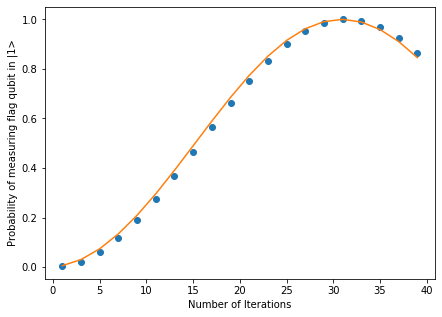

In [7]:
# Set up the state A|00>
flag_qubit = 1
epsilon = 0.05
A_circ = Circuit().ry(0, epsilon).cnot(0,1)

# Add marginal probability for flag qubit as result Type 
A_circ.probability(target=[flag_qubit])

# Let's find the probability of measuring |11> for different values of m, the number of applications of QAA:
probabilities = []
stepsize = 2
iterations = range(1, 40, stepsize)
for m in iterations:
    
    # Get circuit object
    circ = Circuit()
    # Apply QAA using A defined by A_circ
    circ.qaa(A_circ, flag_qubit, m, use_explicit_unitary=True)
    
    # Classically simulate the circuit
    # Give the correct device.run call depending on whether the device is local or on-demand
    if isinstance(device, LocalSimulator):
        task = device.run(circ, shots=0)
    else:
        task = device.run(circ, shots=1000)
        
    # Get result
    result = task.result()
    # Append the probability of measuring |11> for this value of m.
    probabilities.append(result.values[0][1])

# Get analytical result for comparison
probs_theo = [np.sin((2*mm+1)*epsilon/2)**2 for mm in iterations]
    
# Plot the results
plt.figure(figsize=(7,5))
plt.plot(iterations, probabilities, 'o');
plt.plot(iterations, probs_theo);
plt.xlabel('Number of Iterations');
plt.ylabel('Probability of measuring flag qubit in |1>');

As expected, we see that the repeated application of the Grover iterator $\mathcal{Q}$ does increase the amplitude associated with the state $|11\rangle$. 
The probability of measuring the bitstring 11 follows the expected analytical result, given by $(P_{11} = \sin^{2}[(2m+1)\epsilon/2])$, and shown as the solid orange line.
Moreover, we have verified that the optimal number of iterations is approximately given by $\lfloor \frac{\pi}{4\theta}\rfloor= \lfloor \frac{\pi}{2\epsilon}\rfloor \approx 31$.

---
## APPENDIX

In [8]:
# Check SDK version
# alternative: braket.__version__
!pip show amazon-braket-sdk | grep Version

Version: 0.6.0


## APPENDIX: ALTERNATIVE RUN WITH AMPLITUDE RESULT TYPE

Rather than just examining the marginal probability to find the flag qubit in state $|1\rangle$ as done before, we can also investigate the behavior of the amplitude associated with the state $|11\rangle$.
This amplitude is initially given by $\delta=\sin(\epsilon/2)\approx \epsilon/2$ for small $\epsilon$. We can check explicitly that this amplitude increases using repeated applications of the Grover iterator, and recover the plot using the absolute value squared of the amplitudes. 

Using amplitudes also presents a learning opportunity:
If we use $N-1$ ancilla qubits to implement the reflection $\mathcal{R}_{0}$ (by fixing ```use_explicit_unitary = False```), then measurement outcomes are bitstrings of size $N+N-1=2N-1$ (as we measure the original qubits on which the circuit acts, as well as the ancilla qubits).

Since the ancilla qubits are initialized in $|0, 0, ...\rangle$ and are uncomputed back to their initial state in the last step of the algorithm, we can find the amplitude of a given bitstring on the register qubits by padding that target bitstring (for example, $11$ in our example) with the right number ($N-1$) of zeros. 

Using a classical simulator backend, we can attach the corresponding amplitude as a `ResultType` to the circuit, as shown in the following code. 

Amplitude <11|Initial State>:
 {'11': (0.024997395914712332+0j)} 

Maximum amplified amplitude <110|Final State> after approximately 31 Grover iterations:
 {'11': (0.9997837641893592+0j)}


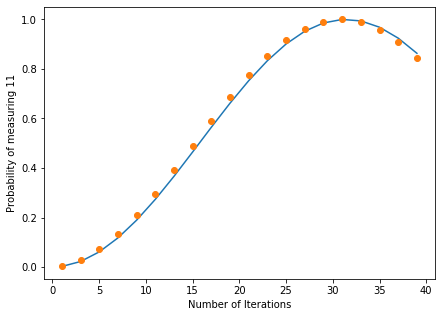

In [9]:
# Set up the state A|00>
flag_qubit = 1
epsilon = 0.05
A_circ = Circuit().ry(0, epsilon).cnot(0,1)

# set switch to either use explicit unitary diag(-1, 1, ...) [True] or use ancillas [False]
use_explicit_unitary = True

# Let's find the probability of measuring |11> for different values of m, the number of applications of QAA:
probabilities = []
stepsize = 2
iterations = range(1, 40, stepsize)
for m in iterations:
    
    # Get circuit object
    circ = Circuit()
    # Apply QAA using A defined by A_circ
    circ.qaa(A_circ, flag_qubit, m, use_explicit_unitary=use_explicit_unitary)
    
    if use_explicit_unitary:
        target_string = '11'
        circ.amplitude(state=[target_string])
    else:
        number_ancillas = A_circ.qubit_count - 1
        target_string = '11'+'0'*number_ancillas
        circ.amplitude(state=[target_string])
    
    # Classically simulate the circuit
    # Execute the correct device.run call depending on whether the device is local or on-demand
    if isinstance(device, LocalSimulator):
        task = device.run(circ, shots=0)
    else:
        task = device.run(circ, shots=0)
    
    # Get result
    result = task.result()   
    # Append the probability of measuring |11> for this value of m.
    probabilities.append(np.linalg.norm(result.values[0][target_string])**2)

# Get analytical result for comparison
probs_theo = [np.sin((2*mm+1)*epsilon/2)**2 for mm in iterations]
    
# Plot the results
plt.figure(figsize=(7,5))
plt.plot(iterations, probabilities);
plt.plot(iterations, probs_theo, 'o');
plt.xlabel('Number of Iterations');
plt.ylabel('Probability of measuring 11');

# Let's compare the amplitude of |11> in the initial state versus the state with maximum probability:
# Print the initial amplitude of |11>

# Add a Result Type to output the amplitude of |11> for A
A_initial = A_circ.copy()
A_initial.amplitude(state=['11'])

if isinstance(device, LocalSimulator):
    initial_result = device.run(A_initial, shots=0).result()
else:
    initial_result = device.run(A_initial, shots=0).result()
print("Amplitude <11|Initial State>:\n", initial_result.values[0],"\n")

# Find the number of iterations required to achieve the maximum probability:
max_prob = max(probabilities)
max_iter = iterations[probabilities.index(max_prob)]

# Generate that state:
circ = Circuit()
circ.qaa(A_circ, flag_qubit, max_iter, use_explicit_unitary=use_explicit_unitary)
circ.amplitude(state=[target_string])

# Run the simulator
if isinstance(device, LocalSimulator):
    task = device.run(circ, shots=0)
    result = task.result()
else:
    task = device.run(circ, shots=0)
    result = task.result()

# Print the final amplitude of |11>:
info = "Maximum amplified amplitude <110|Final State> after approximately"
print(info+" {} Grover iterations:\n {}".format(max_iter, result.values[0]))

---
## References

[1] Wikipedia: [Amplitude Amplification](https://en.wikipedia.org/wiki/Amplitude_amplification).

[2] G. Brassard, P. Høyer, "An exact quantum polynomial-time algorithm for Simon's problem", Proceedings of Fifth Israeli Symposium on Theory of Computing and Systems. IEEE Computer Society Press: 12–23, [arXiv:quant-ph/9704027](https://arxiv.org/abs/quant-ph/9704027) (1997). 

[3] G. Brassard, P. Høyer, M. Mosca, A. Tapp, "Quantum Amplitude Amplification and Estimation", [arXiv:quant-ph/0005055](https://arxiv.org/pdf/quant-ph/0005055.pdf) (2000).

[4] Y. Suzuki, S. Uno, R. Raymond, T. Tanaka, T. Onodera, N. Yamamoto, "Amplitude Estimation without Phase Estimation", [arXiv:1904.10246](https://arxiv.org/pdf/1904.10246.pdf) (2019). 